---
authors:
  - name: "John B. DeSanto"
    id: johnbdesanto
    affiliations:
      - id: uw-ess
    orcid: "0000-0003-4997-364X"
    github: johnbdesanto
---

# **Exercise 1: Introduction to GNATSS**

This exercise will introduce the basic functionality of GNATSS. We will review the required input files and the different modules of the software, as well as process an example data set. At the end of this exercise you should be able to:

* Open and tailor a GNATSS configuration file
* Execute a GNATSS processing run
* Understand the purpose of the posfilter and solver modules
* Access GNATSS output files

Users are recommended to follow this in a github Codespace, where they can directly interact with the required files. The data can be processed either on the command line interface or within this notebook.

## Files present

In this directory you will find a folder called `2022` which contains three items of interest:

* A folder `NCL1` which contains the raw data for this exercise
* A folder `output` where the results of this exercise will be stored
* A configuration file `config.yaml`

The data we will process here is part of the data set collected at a GNSS-Acoustic site NCL1 offshore Cape Lookout, OR during the summer of 2022 as part of the Near-trench Community Geodesy Experiment. It was collected by a Liquid Robots model SV-3 Wave Glider operating a Sonardyne GNSS-A payload, and has been transcribed from the raw glider output to ASCII input files easily read by machine or human.

## Configuration File

Let's start by opening the configuration file so that we can assess the information required in order to run GNATSS. This file is in a [YAML](https://yaml.org/spec/1.2.2/) format, which is a data serialization language that can be easily parsed by both machines and humans. It consists of ASCII text blocks that define different configuration specifications defined within GNATSS itself. The indentation governs how variables are nested within each text block, and individual variables are reported as `key: value` pairs, with the `key` telling GNATSS which variable the value describes and the `value` being the variable itself. The input for variables is flexible and can be strings, integers, or booleans, as needed.

This configuration file has 4 text blocks, described below.

### Metadata

The metadata block defines site parameters essential for processing GNSS-A data. These parameters should be static and unique to the individual site. For this example the metadata is:


```
site_id: NCL1
campaign: Cascadia
time_origin: 2022-09-28 00:00:00
array_center:
  lat: 45.3023
  lon: -124.9656
transponders:
  - lat: 45.302064471
    lon: -124.978181346
    height: -1176.5866
    internal_delay: 0.200000
    sv_mean: 1481.551
  - lat: 45.295207747
    lon: -124.958752845
    height: -1146.5881
    internal_delay: 0.320000
    sv_mean: 1481.521
  - lat: 45.309643593
    lon: -124.959348875
    height: -1133.7305
    internal_delay: 0.440000
    sv_mean: 1481.509
travel_times_variance: 1e-10
travel_times_correction: 0.0
transducer_delay_time: 0.0
```


Of particular note are the array center, defined as the point on the sea surface where the acoustic two-way travel times to each transponder are equivalent, and the transponders metadata. Currently, GNATSS is configured to process data for arrays of three transponders under the assumption that the surface platform (wave glider or ship) interrogates the transponders from the array center and that each transponder replies individually to each ping. In order to guard against overlapping replies, the transponders have a user-defined internal delay (known as the turn-around time or TAT) that staggers the repies. GNATSS automatically removes the TAT when interpreting acoustic data.

### Posfilter

The posfilter block defines parameters required for pre-processing the GNSS-A data and preparing it for the solver by calculating the position of the transducer when pings are sent and replies are received. For a more detailed description of the operations performed, please see the [GNATSS documentation](https://gnatss.readthedocs.io/en/latest/gnssa_preprocessing.html). In brief, this module performs the following steps:

1. Interpolate 1Hz antenna positions to epochs at ping send and reply using a Kalman filter
2. Interpolate 20H inertial navigation system (INS) orientations to epochs at ping send and reply using a simple spline
3. Transform the antenna positions into transducer positions using a rotation of the rigid bodyframe offset between antenna and transducer (also called the antenna-transducer displacement or ATD offset)

This module generates an output file called `gps_solution.csv` in the user-designated output folder. This file includes the travel time and transducer positions for each ping reply in the [Community Standard GNSS-A format](https://hal.science/hal-04319233/).

The posfilter block for this exercise is:

```
# Posfilter configuration
posfilter:
  export:
    full: false # Don't change this
  atd_offsets:
    forward: 0.0053
    rightward: 0
    downward: 0.92813
  input_files:
    novatel:
      path: ../data/exercise-1/2022/NCL1/NOV/NCL1_INSPVAA.dat
    novatel_std:
      path: ../data/exercise-1/2022/NCL1/NOV/NCL1_INSSTDEVA.dat
    gps_positions:
      path: ../data/exercise-1/2022/NCL1/**/GPS_PPP/GPS_POS_FREED
    travel_times:
      path: ../data/exercise-1/2022/NCL1/**/WG_*/pxp_tt
```

Because the surface platform in this exercise is a wave glider, the ATD offsets are known since they were directly measured. The input files are all ASCII text files so you may inspect them as desired. Otherwise, they are described in detail on the [L-1 Data](https://gnatss.readthedocs.io/en/latest/input.html#l-1-data) section of the GNATSS documentation.

### Solver

The solver block defines parameters required to calculate an array position from the `gps_solution.csv` file generated by the posfilter and a user-provided sound velocity profile. The solver input for this exercise is:

```
# Solver configuration
solver:
  reference_ellipsoid:
    semi_major_axis: 6378137.000
    reverse_flattening: 298.257222101
  gps_sigma_limit: 0.05
  std_dev: true
  geoid_undulation: -26.59
  bisection_tolerance: 1e-10
  harmonic_mean_start_depth: -4.0
  input_files:
    sound_speed:
      path: ../data/exercise-1/2022/NCL1/ctd/CTD_NCL1_Ch_Mi
````

Of these parameters, the only one that is site-specific is the geoid height. Other parameters are generally static, although the user can tune the `gps_sigma_limit` parameter if they choose. This governs whether data are included or excluded from the inversion based on whether the 3D RMS of the transducer position uncertainties falls within the threshold. If `gps_sigma_limit` is large more data is included but its positioning may be less well constrained, and vice versa if `gps_sigma_limit` is small.

The sound velocity profile is a two-column text file of depth (relative to the sea surface, _not_ the ellipsoid) and sound velocity. It is assumed that the values in the sound velocity profile extend beneath the seafloor, since it is not possible to collect such data in practice it is recommended that the user extrapolates the sound velocity values in the lower 50 m or so of the water column to achieve this.

### Output

The output specifications are simple and define a directory where procesing results are stored. If the directory does not exist, GNATSS will create it.

```
# Output configuration
output:
  path: ../data/exercise-1/2022/output/
```

## Running the example

Now that we have introduced the input data, we are ready to run this processing example. If you are following along within the Jupyter notebook, import the main executable of gnatss as a dependency:

In [1]:
from gnatss.main import run_gnatss

Before we run any processing, let's quickly assess how to use GNATSS. If you are on the command line, enter the command `gnatss run --help`. The equivalent in python is:

In [2]:
help(run_gnatss)

Help on function run_gnatss in module gnatss.main:

run_gnatss(config_yaml: 'str', distance_limit: 'float | None' = None, residual_limit: 'float | None' = None, residual_range_limit: 'float | None' = None, outlier_threshold: 'float | None' = None, from_cache: 'bool' = False, return_raw: 'bool' = False, remove_outliers: 'bool' = False, extract_process_dataset: 'bool' = True, extract_dist_center: 'bool' = True, qc: 'bool' = True, skip_posfilter: 'bool' = False, skip_solver: 'bool' = False) -> 'tuple[Configuration, dict[str, any]]'
    The main function to run GNATSS from end-to-end.
    
    Parameters
    ----------
    config_yaml : str
        Path to the configuration yaml file
    
    distance_limit : float | None, optional
        Distance in meters from center beyond
        which points will be excluded from solution
    
        *Setting this argument will override the value set in the configuration.*
    
    residual_limit : float | None, optional
        Maximum residual in 

The primary input for GNATSS is the configuration file, with other flags being optional. The only other option we will use for this example is a distance threshold. GNATSS assumes that the wave glider collects data from the center of the array and the processing will start to break down if it drifts too far from this position, so the distance threshold allows the user to automatically ignore any pings collected when the glider was off station. A value of 150 m is recommended, but can be tuned to be more or less strict depending on the context of the survey.

To execute the gnatss example in the command line, enter

```
gnatss run --distance-limit 150 ../data/exercise-1/config.yaml
```

In python:

In [3]:
# Set input variables

config_yaml = "../data/exercise-1/config.yaml"
distance_limit = 150

Starting GNATSS ...
Gathering gps_positions at ../data/exercise-1/2022/NCL1/**/GPS_PPP/GPS_POS_FREED
Gathering novatel at ../data/exercise-1/2022/NCL1/NOV/NCL1_INSPVAA.dat
Gathering novatel_std at ../data/exercise-1/2022/NCL1/NOV/NCL1_INSSTDEVA.dat
Gathering travel_times at ../data/exercise-1/2022/NCL1/**/WG_*/pxp_tt
Gathering sound_speed at ../data/exercise-1/2022/NCL1/ctd/CTD_NCL1_Ch_Mi
Loading gps_positions from ../data/exercise-1/2022/NCL1/**/GPS_PPP/GPS_POS_FREED
Loading novatel from ../data/exercise-1/2022/NCL1/NOV/NCL1_INSPVAA.dat
Loading novatel_std from ../data/exercise-1/2022/NCL1/NOV/NCL1_INSSTDEVA.dat
Loading travel_times from ../data/exercise-1/2022/NCL1/**/WG_*/pxp_tt
Loading sound_speed from ../data/exercise-1/2022/NCL1/ctd/CTD_NCL1_Ch_Mi
Loading deletions from ../data/exercise-1/output/
Preprocessing Travel Times Data
Finished Preprocessing Travel Times Data
Performing Kalman filtering ...
Performing Spline Interpolation ...
Performing Rotation ...
Standardizing data to

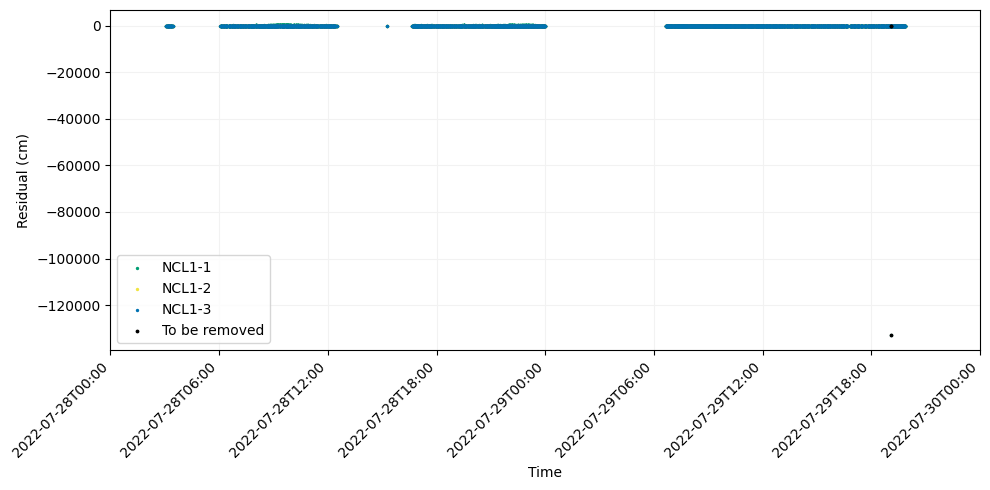

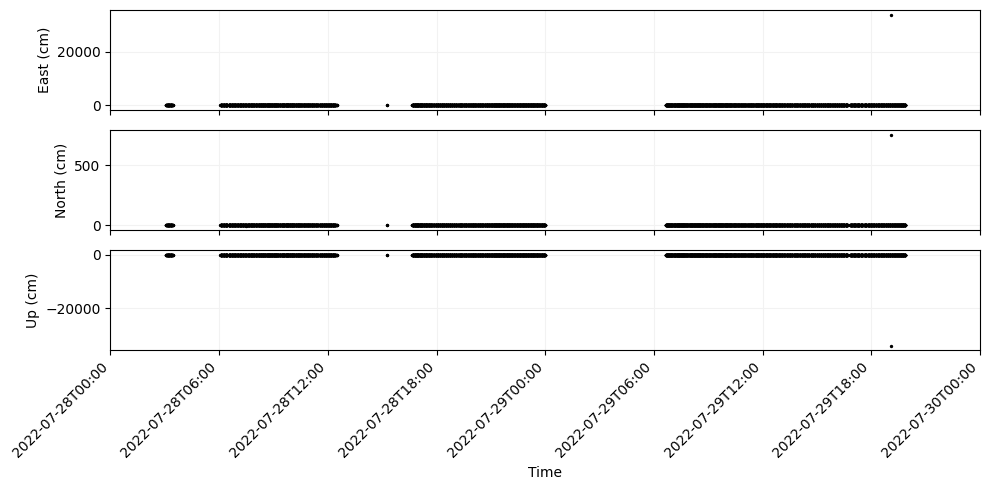

In [4]:
output = run_gnatss(
    config_yaml,
    distance_limit=distance_limit
)

When running, GNATSS generates useful information to standard output that we may use to assess the quality of the inversion. Things that I always pay attention to are the number of epochs included in the inversion (one epoch is equivalent to one ping), the RMS residual, and the error factor. The RMS residual is expressed in centimeters instead of seconds even though it is a travel time residual, this conversion is made by mulitplying the travel time residuals by the harmonic mean sound velocity. The error factor is equivalent to the reduced $\chi^2$ value of the inversion, and is ideally equal to 1 if the data is well fit by the model. However, since in practice we cannot model the oceanographic variations throughout a survey the error factor will inevitably be greater than 1.

The residual plots generated are also an important tool for assessing the quality of the run, although it appears that a single point is obscuring the details in the plots at this time. GNATSS identified this point as an "outlier" and provided instructions for how to fix it. We will have a full discussion of what outliers are and how to interpret them in a later exercise. 

For now, go ahead and follow GNATSS's instructions to remove this outlier in order to refine this solution to something a little more realistic.

*Hint: If you have already run the posfilter, you can save some time on subsequent runs by invoking the ``--from-cache`` flag. This will repeat the previous invocation of the solver using the ``gps_solution.csv`` file that the posfilter previously generated.*